/Users/yeyuan/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


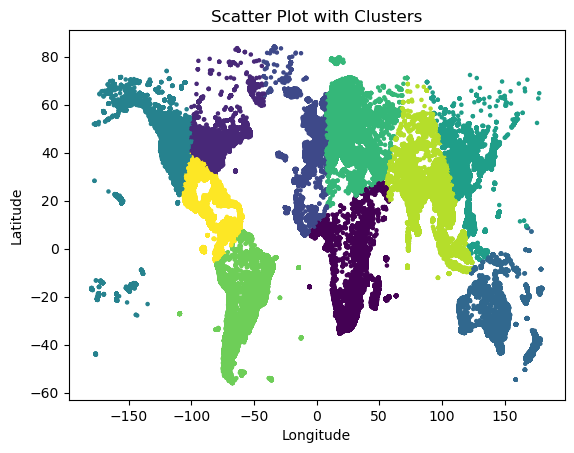

Cluster Counts:
cluster
2    1273488
6     819541
1     807911
4     632528
5     309307
9     294598
8     203674
7     170033
3     153311
0      59304
Name: count, dtype: int64


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 假设有一个包含经纬度信息的DataFrame，命名为df，包含两列：latitude和longitude
df = pd.read_csv("~/Documents/GitHub/GeoEstimation/resources/mp16_places365.csv")
# 数据准备
data = df[['LAT', 'LON']]

# 使用KMeans进行聚类
num_clusters = 10  # 假设聚成5个簇
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data)

# 获取每个点所属的簇
clusters = kmeans.predict(data)

# 将簇信息加入DataFrame
df['cluster'] = clusters

# 绘制散点图，不同簇的点使用不同颜色标记
plt.scatter(df['LON'], df['LAT'], c=df['cluster'], cmap='viridis', s=5)
plt.title('Scatter Plot with Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# 统计每个簇的分布情况
cluster_counts = df['cluster'].value_counts()
print("Cluster Counts:")
print(cluster_counts)


In [2]:
df_val = pd.read_csv("/Users/yeyuan/Documents/GitHub/GeoEstimation/resources/yfcc25600_places365.csv")
num_val = df_val.shape[0]
type(num_val)

int

In [3]:
# 计算每个簇的均值和方差
cluster_stats = df.groupby('cluster')[['LAT', 'LON']].agg(['mean', 'std'])

# 生成10个数据点
num_samples = num_val
generated_data = []

for _ in range(num_samples):
    # 随机选择一个簇ID
    random_cluster_id = np.random.choice(df['cluster'].unique())
    
    # 获取该簇的均值和方差
    mean_latitude = cluster_stats.loc[random_cluster_id, ('LAT', 'mean')]
    std_latitude = cluster_stats.loc[random_cluster_id, ('LAT', 'std')]
    mean_longitude = cluster_stats.loc[random_cluster_id, ('LON', 'mean')]
    std_longitude = cluster_stats.loc[random_cluster_id, ('LON', 'std')]
    
    # 生成符合该簇分布的随机数据点
    random_latitude = np.random.normal(mean_latitude, std_latitude)
    random_longitude = np.random.normal(mean_longitude, std_longitude)
    
    # 添加生成的数据点
    generated_data.append({'LAT_guess': random_latitude, 'LON_guess': random_longitude})

# 将生成的数据点转换为DataFrame
generated_df = pd.DataFrame(generated_data)
print(generated_df)

       LAT_guess   LON_guess
0      46.133014  132.521054
1      55.474690    2.811332
2      26.866114  -94.741207
3      25.779515  -90.360101
4     -42.738117  176.597719
...          ...         ...
25595  40.905035 -118.016608
25596  -7.461112   25.631520
25597  24.702557  112.447017
25598  35.200606 -104.509215
25599  54.771045   22.484461

[25600 rows x 2 columns]


In [4]:
# 拼接两个 DataFrame
combined_df = pd.concat([df_val, generated_df], axis=1)

# 输出合并后的 DataFrame
print(combined_df)


                     IMG_ID        AUTHOR        LAT         LON  S3_Label  \
0      45/77/3228511372.jpg  43008843@N00  46.778991   23.611207         0   
1      2e/b5/4325164013.jpg  22489773@N02  40.445379  116.663990         2   
2      68/42/2195251385.jpg  85976263@N00  47.469907   19.072952         0   
3      87/7b/6786398493.jpg  70806177@N00  31.704666   35.206666         0   
4      8b/a2/5663163551.jpg  46604778@N00  32.654696  -16.907958         2   
...                     ...           ...        ...         ...       ...   
25595  17/76/4774603929.jpg  80547277@N00  45.484977 -123.972977         2   
25596  8c/76/6576441431.jpg  17373191@N00  41.765198  -74.161920         2   
25597  db/a5/2126931545.jpg   9456163@N05  29.422394  -98.488590         1   
25598  14/bf/2419255338.jpg  54177777@N00  37.563710 -122.513260         1   
25599  6e/64/3615351720.jpg  13542313@N00  41.501321  -81.690709         2   

       S16_Label  S365_Label   Prob_indoor  Prob_natural  Prob_

In [5]:


def vectorized_gc_distance(latitudes, longitudes, latitudes_gt, longitudes_gt):
    R = 6371
    factor_rad = 0.01745329252
    longitudes = factor_rad * longitudes
    longitudes_gt = factor_rad * longitudes_gt
    latitudes = factor_rad * latitudes
    latitudes_gt = factor_rad * latitudes_gt
    delta_long = longitudes_gt - longitudes
    delta_lat = latitudes_gt - latitudes
    subterm0 = np.sin(delta_lat / 2) ** 2
    subterm1 = np.cos(latitudes) * np.cos(latitudes_gt)
    subterm2 = np.sin(delta_long / 2) ** 2
    subterm1 = subterm1 * subterm2
    a = subterm0 + subterm1
    c = 2 * np.arcsin(np.sqrt(a))
    gcd = R * c
    return gcd


In [6]:
combined_df['distance'] = combined_df.apply(
    lambda row: vectorized_gc_distance(row['LAT'], row['LON'], row['LAT_guess'], row['LON_guess']),
    axis=1
)

In [7]:
combined_df

,IMG_ID,AUTHOR,LAT,LON,S3_Label,S16_Label,S365_Label,Prob_indoor,Prob_natural,Prob_urban,LAT_guess,LON_guess,distance
0,45/77/3228511372.jpg,43008843@N00,46.778991,23.611207,0,5,21,9.786990e-01,0.001071,0.020230,46.133014,132.521054,7582.095742
1,2e/b5/4325164013.jpg,22489773@N02,40.445379,116.663990,2,14,201,1.687362e-02,0.366694,0.616432,55.474690,2.811332,7661.002419
2,68/42/2195251385.jpg,85976263@N00,47.469907,19.072952,0,5,250,9.645445e-01,0.000001,0.035454,26.866114,-94.741207,9436.318685
3,87/7b/6786398493.jpg,70806177@N00,31.704666,35.206666,0,5,169,9.125900e-01,0.005846,0.081565,25.779515,-90.360101,11401.382181
4,8b/a2/5663163551.jpg,46604778@N00,32.654696,-16.907958,2,14,268,1.941495e-01,0.118745,0.687105,-42.738117,176.597719,18385.201500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,17/76/4774603929.jpg,80547277@N00,45.484977,-123.972977,2,7,116,3.012353e-02,0.461205,0.508672,40.905035,-118.016608,701.387112
25596,8c/76/6576441431.jpg,17373191@N00,41.765198,-74.161920,2,9,340,1.525349e-02,0.482444,0.502303,-7.461112,25.631520,11370.415063
25597,db/a5/2126931545.jpg,9456163@N05,29.422394,-98.488590,1,6,277,2.456120e-02,0.783856,0.191583,24.702557,112.447017,13149.754396
25598,14/bf/2419255338.jpg,54177777@N00,37.563710,-122.513260,1,6,48,7.339240e-07,0.999492,0.000508,35.200606,-104.509215,1630.399476


In [8]:


# 计算地理距离在不同范围内的数量
within_100 = combined_df[combined_df['distance'] <= 100].shape[0]
within_500 = combined_df[combined_df['distance'] <= 500].shape[0]
within_1000 = combined_df[combined_df['distance'] <= 1000].shape[0]
within_2000 = combined_df[combined_df['distance'] <= 2000].shape[0]
# 计算总行数
total_rows = combined_df.shape[0]

# 计算不同范围内的比例
percentage_within_100 = within_100 / total_rows * 100
percentage_within_500 = within_500 / total_rows * 100
percentage_within_1000 = within_1000 / total_rows * 100
percentage_within_2000 = within_2000 / total_rows * 100

# 打印结果
print(f"平均距离：{combined_df['distance'].mean()}")
print(f"100公里内的比例：{percentage_within_100}%")
print(f"500公里内的比例：{percentage_within_500}%")
print(f"1000公里内的比例：{percentage_within_1000}%")
print(f"2000公里内的比例：{percentage_within_2000}%")

平均距离：8450.04943386797
100公里内的比例：0.0859375%
500公里内的比例：1.76953125%
1000公里内的比例：5.6640625%
2000公里内的比例：12.898437500000002%


列表中的张量都不包含 NaN


In [5]:
import torch

# 创建一个只有一个数字的张量
number = torch.tensor(1)

# 检查这个数字是否是 NaN
is_nan = torch.isnan(number)

print(is_nan)
if is_nan:
    print("yes")

tensor(False)
